# load library

In [1]:
source("r/jupyter_common.R")

source("r/enrichment_analysis.R")
source("r/find_markers.R")
source("r/identify_cell_types.R")
source("r/plot_sc_clusters.R")


In [2]:
# data structure
suppressPackageStartupMessages(library(stringi))
suppressPackageStartupMessages(library(forcats))

# utils
suppressPackageStartupMessages(library(amap)) # for Dist()
suppressPackageStartupMessages(library(scales))

# scRNA-seq
suppressPackageStartupMessages(library(Seurat))



## parallel

In [3]:
suppressPackageStartupMessages(library(future))
plan("multicore", workers = 8)

options(future.globals.maxSize = 5 * 1024^3) # 5GB


# parameters

In [4]:
cancer_type <- "er+bc-pairs"


args <- list()
args$cancer_type <- cancer_type
args$method_to_identify_cell_types <- "singler_blueprint_encode"
args$seurat_resolution <- 0.8
args$harmony_theta <- 0

str_column_of_meta_data_cluster <- sprintf("RNA_snn_res.%g", args$seurat_resolution)
str_column_of_meta_data_harmony <- sprintf("RNA_harmony_th.%s", paste(args$harmony_theta, collapse=","))

str_reduction <- "pca"
str_umap_reduction <- "umap"  
col_cluster_types <- "cluster.type"

str_condition <- cancer_type

str_condition
str_column_of_meta_data_cluster
str_umap_reduction
col_cluster_types

figure_format <- "pdf"




[1] "er+bc-pairs"

[1] "RNA_snn_res.0.8"

[1] "umap"

[1] "cluster.type"

## set.seed

In [5]:
# set seed for reproducibility
set.seed(51)



## display

In [6]:
options(repr.matrix.max.cols=150, repr.matrix.max.rows=50)


## nv_cell_type_conversion_table

In [7]:
nv_cell_type_conversion_table <- c(
            "Epithelial cells"="Epi. CNA-",
            "Normal-like"="Normal-like",
            "Basal"="Basal",
            "Her2"="Her2",
            "LumA"="LumA",
            "LumB"="LumB")


# read scRNA-seq

In [8]:

dir_rna <- "/home/hkim77/spanheimer_lab.w/sc-rna-seq/tr-bc/run-20220121"
fname_rna <- sprintf("%s/output/rds_%s/%s_sc-rna-seq_merged_seurat_obj.rds",
                     dir_rna, cancer_type, cancer_type)
fname_rna

rna <- readRDS(fname_rna)



[1] "/home/hkim77/spanheimer_lab.w/sc-rna-seq/tr-bc/run-20220121/output/rds_er+bc-pairs/er+bc-pairs_sc-rna-seq_merged_seurat_obj.rds"

https://mojaveazure.github.io/seurat-object/reference/Seurat-methods.html

dim: The number of features (nrow) and cells (ncol) for the default assay; note: while the number of features changes depending on the active assay, the number of cells remains the same across all assays


## mapping sample IDs

In [9]:
df_id_map <- read.table("tsv/sample_id_mapping_table.tsv",
                     sep="\t",
                     header=T,
                     row.names=1)

idx <- match(rna@meta.data[, "Sample"], rownames(df_id_map))
rna@meta.data[, "Sample"] <- df_id_map[idx, 1]


## n_samples

In [10]:
samples <- unique(rna@meta.data$Sample)
samples

n_samples <- length(samples)
n_samples


[1] "Tumor_03_Control"   "Tumor_03_Tamoxifen" "Tumor_05_Control"  
[4] "Tumor_05_Tamoxifen" "Tumor_06_Control"   "Tumor_06_Tamoxifen"
[7] "Tumor_08_Control"   "Tumor_08_Tamoxifen"

[1] 8

## mtx

In [11]:
if (DefaultAssay(rna) == "integrated") {
    mtx <- GetAssayData(object = rna, assay=NULL, slot = "data")
} else {
    mtx <- GetAssayData(object = rna, assay="RNA", slot = "data")
}


## list_sort

In [12]:

list_sort <- sort_cluster_members(rna, args,
                    col_cluster_types = col_cluster_types,
                    str_umap_reduction = str_umap_reduction,
                    f_merge_immune_cell = FALSE)


## colors

### samples

[1] "#A6CEE3" "#1F78B4" "#B2DF8A" "#33A02C" "#FB9A99" "#E31A1C" "#FDBF6F"
[8] "#FF7F00"

[1] 8

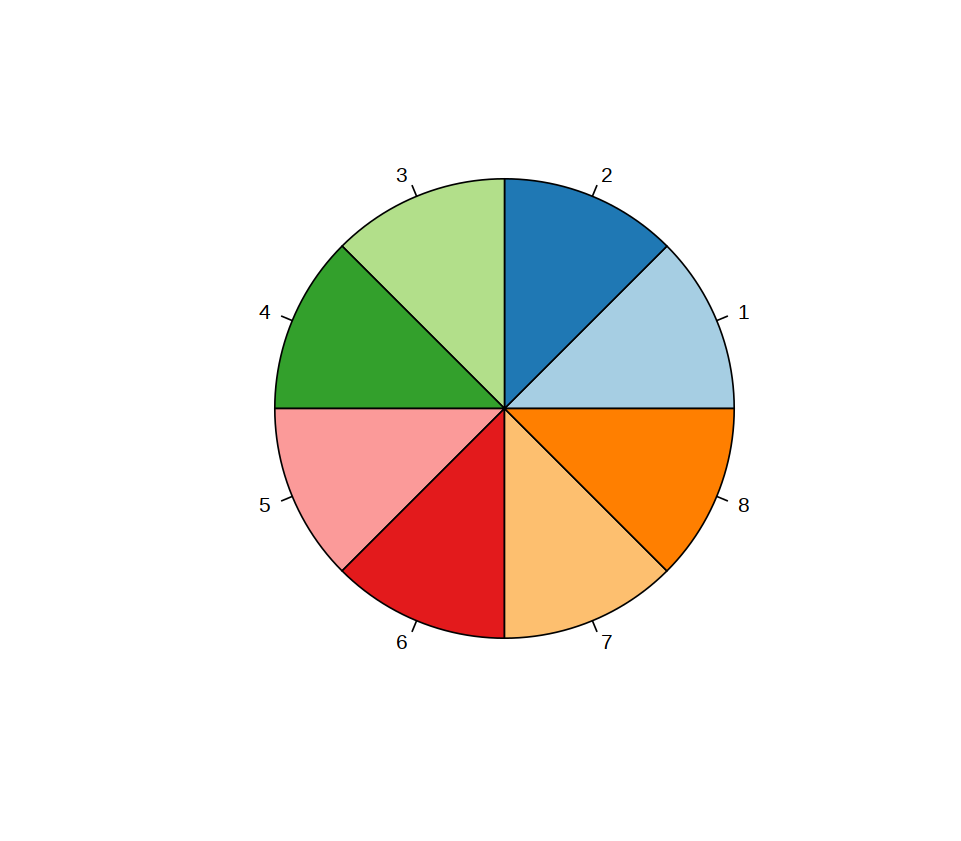

In [13]:
# make patient sample metadata and color assignments 
# http://applied-r.com/rcolorbrewer-palettes/

if (n_samples <= 4) {
    sampleColors <- brewer.pal(12, "Paired")
    sampleColors <- sampleColors[c(1,5,2,6)]
} else if (n_samples <= 12){
    sampleColors <- brewer.pal(n_samples, "Paired")
} else {
    vec_color1 <- colorRampPalette(brewer.pal(9, "Set1"))(n_samples/2)
    vec_color2 <- colorspace::lighten(vec_color1, amount=0.4) 
    sampleColors <- c(rbind(vec_color1, vec_color2))
}

sampleColors
length(sampleColors)

options(repr.plot.width=8.01, repr.plot.height=7.01)
pie(rep(1,n_samples), col=sampleColors) 


### epi

[1] "Epithelial cells" "Epi. Non-tumor"   "LEp_prog"         "LEp_secretory"   
 [5] "LEp"              "LEp_hormone"      "BEp"              "BEp_MaSCs"       
 [9] "BEp_myo"          "Epi. Unassigned"  "Epi. Tumor"       "Normal-like"     
[13] "NBL"              "Basal"            "CLow"             "Her2E"           
[17] "LumA"             "LumB"             "Keratinocytes"

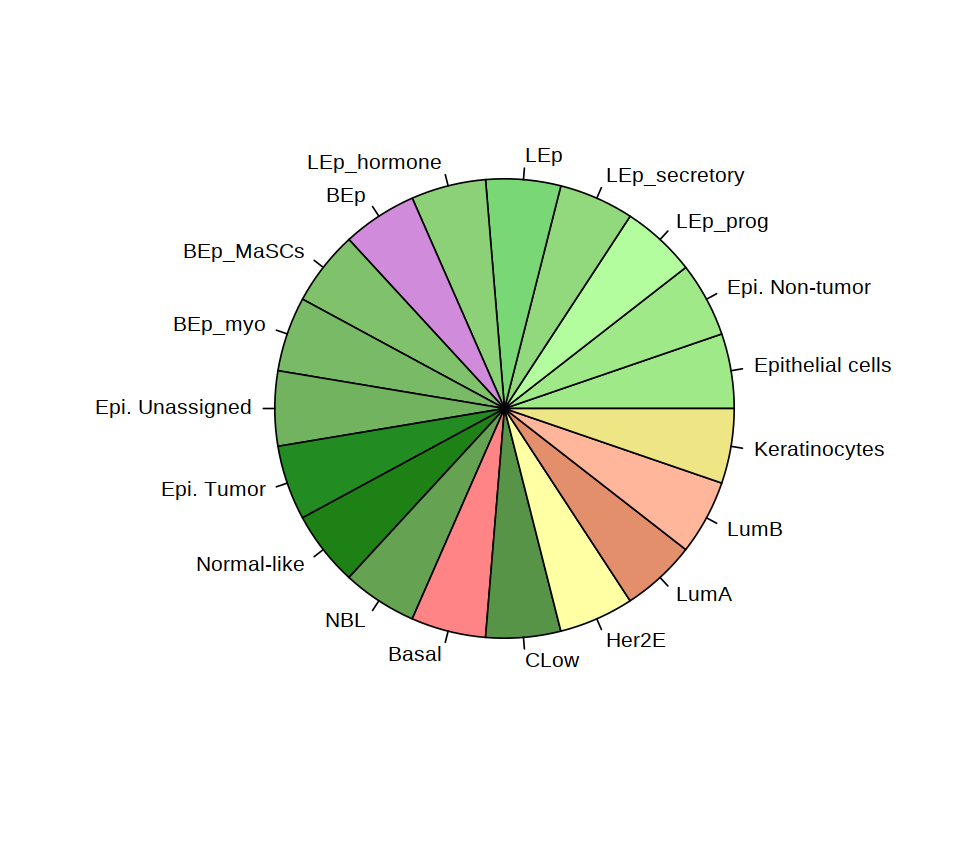

In [14]:
idx_epi <- grep(pattern_epi, names(nv_color))
names(nv_color)[idx_epi]
# http://applied-r.com/rcolorbrewer-palettes/
colors_epi <- RColorBrewer::brewer.pal(9, "Set1")
colors_epi <- colorspace::lighten(colors_epi, amount=0.4)

nv_color["Epi. Tumor"] <- "forestgreen"

nv_color["LEp_prog"] <- "#b4fd9e"
nv_color["LEp"] <- colors_epi[3]
nv_color["BEp"] <- colors_epi[4]

nv_color["Basal"] <- colors_epi[1]
nv_color["Her2E"] <- colors_epi[6]
nv_color["Her2"] <- colors_epi[6]
nv_color["LumA"] <- colors_epi[7]
nv_color["LumB"] <- colors_epi[5]
nv_color["Normal-like"] <- colorspace::darken(colors_epi[3], amount=0.4)

pie(rep(1, length(idx_epi)), col=nv_color[idx_epi],
       labels=names(nv_color)[idx_epi]) 


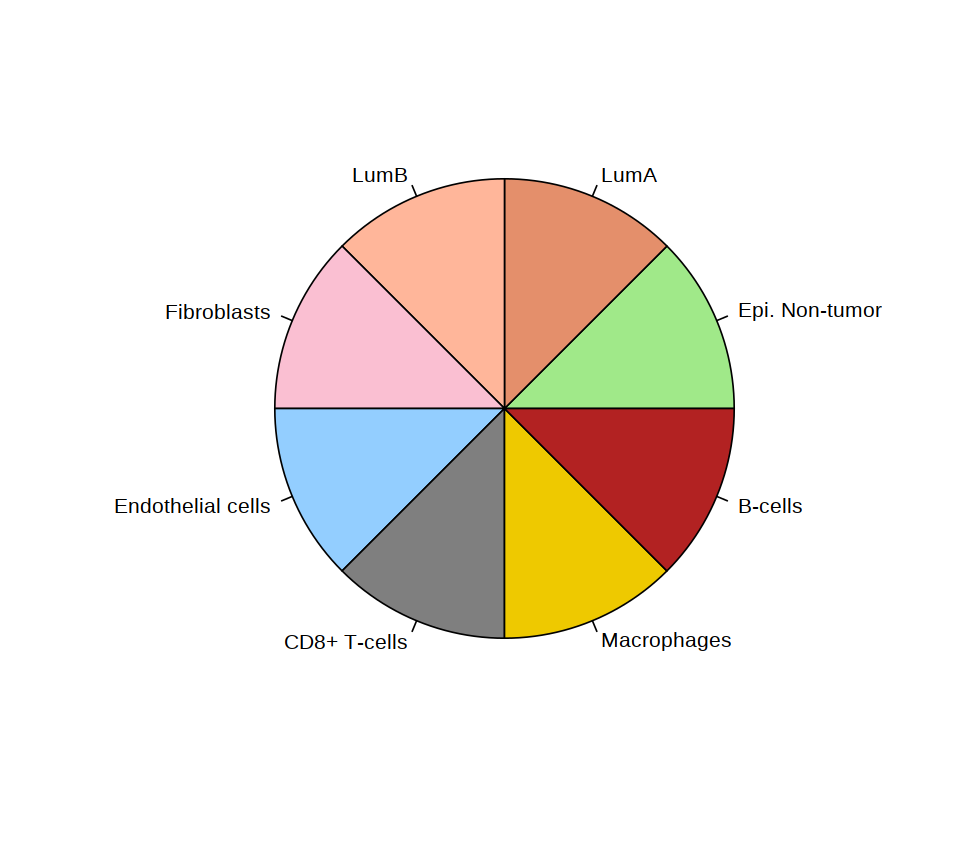

In [15]:
list_sort <- update_nv_color_cell_type(list_sort)
colors_epi <- list_sort$nv_color_cell_type

pie(rep(1, length(colors_epi)), col=colors_epi,
       labels=names(colors_epi)) 


### cell.type

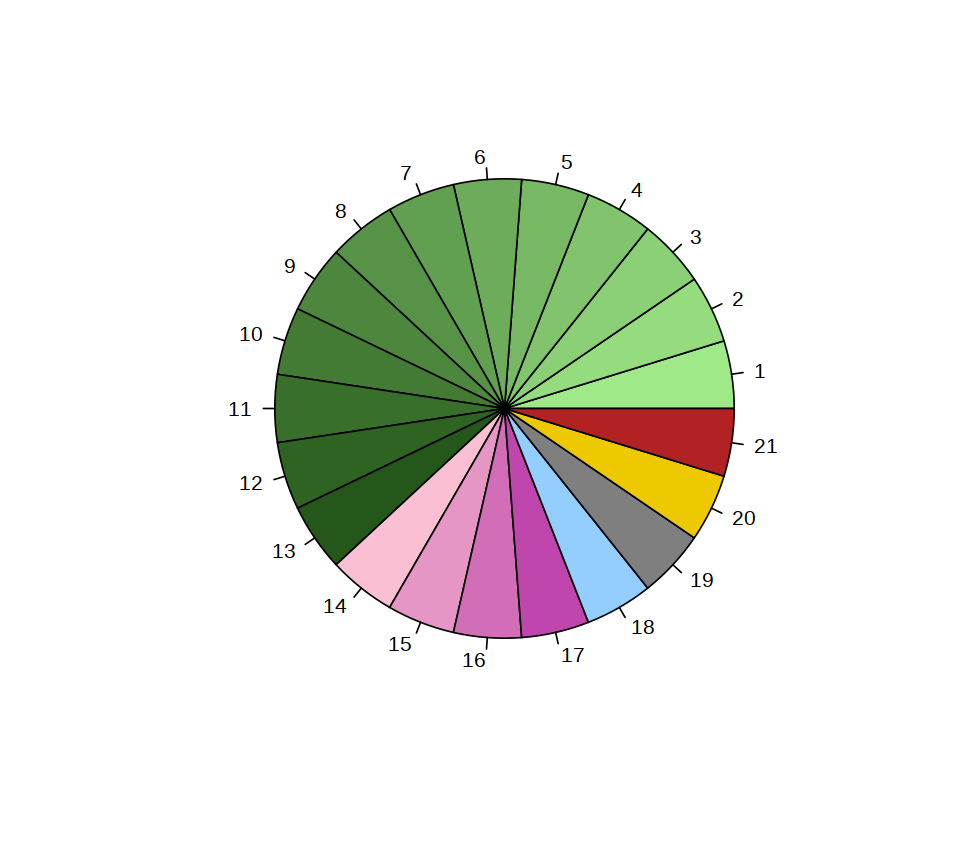

In [16]:
options(repr.plot.width=8.01, repr.plot.height=7.01)
pie(rep(1, length(list_sort$nv_color_cluster_type_ordered)),
    col=list_sort$nv_color_cluster_type_ordered) 


# DGE

## gmt

In [17]:

list_gmt <- list()
list_gmt[["h"]] <- read.gmt("reference/gmt/h.all.v6.1.symbols.gmt")
list_gmt[["unc_lccc"]] <- read.gmt("reference/gmt/unc_lccc_human_gene_signatures.gmt")



## type_condition

In [18]:

method_dge <- "seurat_findmarkers_enricher"
dir_xlsx <- "xlsx"

list_genes_dn <- list()


# additional conditions 
genes <- NULL
str_cond1 <- NULL
str_cond_ref <- NULL
type_condition <- "none"



## cluster 2 vs. cluster 3

In [19]:
# tumor pairs with large differences

sample1 <- NULL
sample_ref <- NULL

th_log2fc_=0.25; th_padj_=0.01
min.pct_=0.25; min.diff.pct_=-Inf; max.cells.per.ident_=Inf

f_featureplot=FALSE
n_sampling=-1
cluster_rows=FALSE

pattern_sample1 <- "Tamoxifen"
pattern_sample_ref <- "Tamoxifen"

drug_name <- "tamoxifen"

clusters1 <- c(3)  # 2 vs. 3 LumA, n=865
#clusters1 <- c(12)  # 2 vs. 12 LumA, n=345
#clusters1 <- c(3,12)  # 2 vs. (3+12) LumA, n=1210
#clusters1 <- c(19)  # 2 vs. 19 LumB, n=100

clusters_ref <- c(2) # reponsive, n=2100

group_name1 <- sprintf("cluster%s", paste(clusters1, collapse=","))
group_name_ref <- sprintf("cluster%s", paste(clusters_ref, collapse=","))

col_cluster_types_ <- NULL
col_cell_types_ <- "cell.type"



In [20]:

cat(sprintf("sample1=%s\n", sample1))
cat(sprintf("sample_ref=%s\n", sample_ref))

cat(sprintf("drug_name=%s\n", drug_name))
cat(sprintf("pattern_sample1=%s\n", pattern_sample1))
cat(sprintf("pattern_sample_ref=%s\n", pattern_sample_ref))

    cat(sprintf("\t\tgroup_name1=%s\n", group_name1))
    cat(sprintf("\t\tgroup_name_ref=%s\n", group_name_ref))
    cat(sprintf("\t\tcol_cluster_types_=%s\n", col_cluster_types_))
    cat(sprintf("\t\tcol_cell_types_=%s\n", col_cell_types_))

    cat(sprintf("\t\tth_log2fc=%g\n", th_log2fc_))
    cat(sprintf("\t\tth_padj=%g\n", th_padj_))
    cat(sprintf("\t\tmin.pct=%g\n", min.pct_))
    cat(sprintf("\t\tmin.diff.pct=%g\n", min.diff.pct_))
    cat(sprintf("\t\tmax.cells.per.ident=%g\n", max.cells.per.ident_))
    cat(sprintf("\t\tmethod_dge=%s\n", method_dge))

    cat(sprintf("\t\ttype_condition=%s\n", type_condition))
    cat(sprintf("\t\tgenes=%s\n", paste(genes, collapse=", ")))
    cat(sprintf("\t\tstr_cond1=%s\n", str_cond1))
    cat(sprintf("\t\tstr_cond_ref=%s\n", str_cond_ref))



drug_name=tamoxifen
pattern_sample1=Tamoxifen
pattern_sample_ref=Tamoxifen
		group_name1=cluster3
		group_name_ref=cluster2
		col_cell_types_=cell.type
		th_log2fc=0.25
		th_padj=0.01
		min.pct=0.25
		min.diff.pct=-Inf
		max.cells.per.ident=Inf
		method_dge=seurat_findmarkers_enricher
		type_condition=none
		genes=


seurat_findmarkers_enricher         col_log2fc=avg_log2FC         col_pvalue=p_val         col_padj=p_val_adj         th_log2fc=0.25         th_padj=0.01

df_up

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,expr_min,expr_mean,expr_max
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ACTB,6.808906e-193,1.4023918,1.000,0.977,1.654973e-188,0.8691134,2.8248663,4.089300
MAP9,7.315661e-170,0.3318075,0.418,0.007,1.778144e-165,-0.3407625,0.1821948,1.626550
MYL6,6.059284e-160,0.9252911,1.000,1.000,1.472770e-155,0.8082293,3.1149004,4.106468
PKIB,1.166690e-151,0.4605322,0.521,0.034,2.835757e-147,-0.3844361,0.2668200,1.676520
ME1,3.852815e-150,0.2576544,0.382,0.001,9.364651e-146,-0.1422437,0.1420609,1.478560
MARCKS,9.407972e-148,0.5061800,0.623,0.038,2.286702e-143,-0.6267424,0.2951444,1.910405


[1] 603   8

df_dn

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,expr_min,expr_mean,expr_max
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SLC3A2,4.077649e-216,-1.404636,0.954,1.000,9.911133e-212,0,2.00442304,4.055056
MT1G,2.351338e-204,-3.923986,0.030,0.809,5.715163e-200,0,0.03373129,2.357016
MTRNR2L8,3.295584e-202,-2.086704,0.248,1.000,8.010247e-198,0,0.63766998,4.351839
NUPR1,1.764460e-193,-1.562209,0.443,1.000,4.288696e-189,0,1.11072400,5.360088
HSPA5,1.098809e-191,-1.682083,0.716,0.998,2.670766e-187,0,1.28477873,3.872525
HERPUD1,2.439895e-182,-1.514899,0.339,0.970,5.930410e-178,0,0.42779816,2.970285


[1] 637   8

up h

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
HALLMARK_OXIDATIVE_PHOSPHORYLATION,HALLMARK_OXIDATIVE_PHOSPHORYLATION,HALLMARK_OXIDATIVE_PHOSPHORYLATION,38/298,200/4386,2.654587e-09,1.327294e-07,1.061835e-07,ATP6V0E1/CPT1A/LDHB/NDUFA4/NDUFB3/LDHA/COX6B1/ATP1B1/NDUFV2/NDUFC2/COX6C/COX7A2/MGST3/NDUFS6/GPI/UQCR10/COX6A1/UQCR11/NDUFB2/UQCRH/NDUFB4/UQCRQ/NDUFA2/COX7B/COX5A/NDUFAB1/NDUFB1/NDUFC1/COX5B/TIMM8B/COX4I1/NDUFB6/CYB5A/SDHC/NDUFA8/NDUFA3/IDH2/NDUFB7,38
HALLMARK_MYC_TARGETS_V1,HALLMARK_MYC_TARGETS_V1,HALLMARK_MYC_TARGETS_V1,36/298,200/4386,3.235485e-08,8.088711e-07,6.470969e-07,HSPE1/LDHA/PPIA/RAN/PSMB3/SRSF2/PSMA7/NHP2/SET/YWHAE/SNRPD1/NME1/SSBP1/SRSF3/COX5A/HDAC2/SNRPG/PGK1/NDUFAB1/SNRPD3/CCT2/XPO1/PSMA1/C1QBP/CCT3/EIF4A1/SNRPD2/HNRNPA2B1/PSMB2/PSMA4/SRSF7/NOP56/PHB/HNRNPD/UBE2L3/LSM2,36
HALLMARK_ESTROGEN_RESPONSE_EARLY,HALLMARK_ESTROGEN_RESPONSE_EARLY,HALLMARK_ESTROGEN_RESPONSE_EARLY,29/298,200/4386,6.250329e-05,7.812911e-04,6.250329e-04,CISH/KRT15/KRT19/KRT8/CCND1/TSKU/NPY1R/LAD1/HSPB8/TGM2/PRSS23/SLC9A3R1/INHBB/RARA/MUC1/ABHD2/AMFR/IGFBP4/TFF3/SLC7A2/PEX11A/MYOF/SCNN1A/RHOBTB3/KRT18/TFF1/FKBP4/CLDN7/XBP1,29
HALLMARK_ESTROGEN_RESPONSE_LATE,HALLMARK_ESTROGEN_RESPONSE_LATE,HALLMARK_ESTROGEN_RESPONSE_LATE,29/298,200/4386,6.250329e-05,7.812911e-04,6.250329e-04,BTG3/CISH/CPE/KRT19/CCND1/NPY1R/MDK/HSPB8/FABP5/ATP2B4/CD9/PRSS23/SLC9A3R1/COX6C/S100A9/MOCS2/CDH1/ABHD2/AMFR/IGFBP4/TFF3/MYOF/SCNN1A/CXCL14/BATF/TFF1/FKBP4/IDH2/XBP1,29
HALLMARK_MTORC1_SIGNALING,HALLMARK_MTORC1_SIGNALING,HALLMARK_MTORC1_SIGNALING,27/298,200/4386,3.779901e-04,3.779901e-03,3.023921e-03,ME1/PLOD2/FADS2/FADS1/STC1/HSPE1/TPI1/LDHA/PRDX1/CD9/PPIA/SLC9A3R1/SCD/PPA1/GPI/GLRX/ENO1/EGLN3/GAPDH/CACYBP/PGK1/STIP1/TES/CCT6A/PSMA4/XBP1/HSPA4,27


[1] 5 9

up unc_lccc

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GATA3.induced.genes_JCO.2006_PMID.16505416,GATA3.induced.genes_JCO.2006_PMID.16505416,GATA3.induced.genes_JCO.2006_PMID.16505416,52/580,277/19993,2.266054e-27,8.905591e-25,5.844033e-25,TACSTD2/HSPB1/S100A11/PRR15L/KRT15/SECTM1/KRT19/KRT8/SLC16A3/LAD1/GATA3/CEACAM6/FXYD3/CD24/ALDH1A3/TM4SF1/EGR1/SAMD12/C19orf33/VAMP8/CLU/ATP1B1/CD9/SLC9A3R1/S100A9/INHBB/SDC1/CALM1/LGALS3BP/ARPC1B/TFF3/MYOF/ID1/CYP1B1/TSPAN15/S100A4/SMIM22/KRT7/KRT18/ADIRF/BATF/TFF1/NDUFB9/ARHGDIB/OCIAD2/CLDN4/S100A16/CLDN7/CLDN3/CRIP2/XBP1/TMC5,52
T47D_control_vs_tamoxifen_down_Tumor cells,T47D_control_vs_tamoxifen_down_Tumor cells,T47D_control_vs_tamoxifen_down_Tumor cells,30/580,107/19993,1.423349e-21,2.796880e-19,1.835371e-19,DYNLL1/ATP5MC3/HSP90AA1/JPT1/KRT19/MARCKSL1/SLC40A1/LDHA/NDUFC2/RUNX1/IGFBP4/ID1/SFPQ/ENO1/TUBB4B/THBS1/HNRNPM/CCT2/ARPC5/FKBP4/CCT3/SNRPB/DNAJA1/HNRNPA2B1/GOLM1/NDUFA8/SRSF7/TMBIM4/TRPS1/DEGS2,30
MCF7.E2.induced.genes_JCO.2006_PMID.16505416,MCF7.E2.induced.genes_JCO.2006_PMID.16505416,MCF7.E2.induced.genes_JCO.2006_PMID.16505416,43/580,290/19993,1.053687e-18,1.380330e-16,9.058013e-17,ACTB/PKIB/BTG3/KRT15/HIF1A/JPT1/FADS1/KRT8/CCND1/TUBB6/NPY1R/LAD1/FABP5/ATP1B1/PRSS23/TPM3/RAN/CORO1C/TPM1/SRSF2/SCD/AMFR/IGFBP4/SNRPD1/SPATS2L/TPM4/ACTN1/LETM1/SRSF3/CYP1B1/DHX9/RAB32/HIGD1A/TFF1/FKBP4/ALYREF/DIAPH1/ARF6/RBM8A/CCT6A/NOP56/XBP1/ZFP36L2,43
MITO1_BMC.Med.Genomics.2011_PMID.21214954,MITO1_BMC.Med.Genomics.2011_PMID.21214954,MITO1_BMC.Med.Genomics.2011_PMID.21214954,16/580,38/19993,2.527547e-15,2.483315e-13,1.629602e-13,DYNLL1/POMP/TXN/TMA7/COX7A2/SEM1/COX6A1/UQCR11/NDUFB2/UQCRQ/NDUFB1/NDUFC1/COX5B/TIMM8B/LSM5/ORMDL2,16
UNC_HS_Green20_BMC.Med.Genomics.2011_PMID.21214954,UNC_HS_Green20_BMC.Med.Genomics.2011_PMID.21214954,UNC_HS_Green20_BMC.Med.Genomics.2011_PMID.21214954,30/580,174/19993,3.179204e-15,2.498854e-13,1.639800e-13,ACTB/MARCKS/PLOD2/S100A11/HIF1A/JPT1/VIM/SLC16A3/MX1/TUBB6/PLAUR/CTSL/PLAU/S100A10/FLNA/CKLF/IFI6/TIMP2/S100A9/CORO1C/ARPC2/PSMA7/SPATS2L/TPM4/S100A4/MSN/CAPZB/CTSB/CD74/NPC2,30
UNC_HS_Red25_BMC.Med.Genomics.2011_PMID.21214954,UNC_HS_Red25_BMC.Med.Genomics.2011_PMID.21214954,UNC_HS_Red25_BMC.Med.Genomics.2011_PMID.21214954,27/580,143/19993,7.643772e-15,5.006671e-13,3.285481e-13,ZFHX3/HSPB1/PRR15L/STC1/CALML5/CEACAM6/FXYD3/CACNG4/SLC9A3R1/PSMB3/CDH1/ITGB6/RARA/SCD/SYNGR2/CEACAM5/TFF3/SLC12A2/APRT/ITGA3/GPRC5A/TFF1/ZNF217/PHB/FKBP3/ORMDL2/SNF8,27


[1] 117   9

down h

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
HALLMARK_UNFOLDED_PROTEIN_RESPONSE,HALLMARK_UNFOLDED_PROTEIN_RESPONSE,HALLMARK_UNFOLDED_PROTEIN_RESPONSE,35/232,113/4386,8.898574e-19,4.182330e-17,3.278422e-17,HSPA5/HERPUD1/DDX10/SERP1/HSP90B1/ASNS/CEBPG/DNAJB9/PDIA6/HYOU1/MTHFD2/ATF4/DDIT4/DNAJC3/EIF2AK3/HSPA9/SRPRB/FKBP14/PDIA5/CALR/PSAT1/SSR1/EXOSC1/CKS1B/TSPYL2/SLC1A4/IARS/CHAC1/EIF4EBP1/VEGFA/SEC31A/ATF3/WIPI1/CEBPB/XPOT,35
HALLMARK_MTORC1_SIGNALING,HALLMARK_MTORC1_SIGNALING,HALLMARK_MTORC1_SIGNALING,43/232,200/4386,2.677399e-16,6.291888e-15,4.932051e-15,NUPR1/HSPA5/DDIT3/PHGDH/SDF2L1/SERP1/HSP90B1/TRIB3/ASNS/SQSTM1/GOT1/SQLE/TCEA1/CANX/HMGCR/MTHFD2/TUBA4A/FAM129A/DDIT4/HSPA9/SHMT2/CALR/HMGCS1/EPRS/PSAT1/SSR1/FKBP2/IDI1/IFRD1/SLC1A4/USO1/EIF2S2/PPP1R15A/UFM1/LDLR/SLC7A11/EBP/INSIG1/RPN1/DHCR7/HSPD1/BHLHE40/TXNRD1,43
HALLMARK_CHOLESTEROL_HOMEOSTASIS,HALLMARK_CHOLESTEROL_HOMEOSTASIS,HALLMARK_CHOLESTEROL_HOMEOSTASIS,18/232,74/4386,2.793102e-08,4.375860e-07,3.430125e-07,TRIB3/STX5/SQLE/HMGCR/FAM129A/MVD/HMGCS1/HSD17B7/IDI1/FDPS/SREBF2/ECH1/PNRC1/ATF3/LDLR/TNFRSF12A/EBP/DHCR7,18
HALLMARK_PROTEIN_SECRETION,HALLMARK_PROTEIN_SECRETION,HALLMARK_PROTEIN_SECRETION,18/232,96/4386,1.840627e-06,2.162737e-05,1.695315e-05,ARFGAP3/LMAN1/COPE/ARCN1/RAB9A/SEC24D/GOLGA4/RAB5A/BET1/ARF1/USO1/TPD52/SEC31A/TMED10/ICA1/COPB2/DST/NAPA,18
HALLMARK_TNFA_SIGNALING_VIA_NFKB,HALLMARK_TNFA_SIGNALING_VIA_NFKB,HALLMARK_TNFA_SIGNALING_VIA_NFKB,26/232,200/4386,1.349707e-05,1.268724e-04,9.945207e-05,SQSTM1/EIF1/GEM/RIPK2/BTG1/CD44/HBEGF/GADD45A/VEGFA/PPP1R15A/JUN/PNRC1/TNFAIP8/REL/IRF1/ATF3/LDLR/CEBPB/TRIB1/TSC22D1/NFKBIA/DUSP1/LITAF/BHLHE40/KLF6/GADD45B,26
HALLMARK_ANDROGEN_RESPONSE,HALLMARK_ANDROGEN_RESPONSE,HALLMARK_ANDROGEN_RESPONSE,17/232,101/4386,1.638811e-05,1.283735e-04,1.006287e-04,LMAN1/DNAJB9/PGM3/HMGCR/HMGCS1/SEC24D/HOMER2/IDI1/TPD52/SLC38A2/TNFAIP8/SRP19/H1F0/TSC22D1/INSIG1/GNAI3/ITGAV,17


[1] 9 9

down unc_lccc

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
UNC_HS_Red22_BMC.Med.Genomics.2011_PMID.21214954,UNC_HS_Red22_BMC.Med.Genomics.2011_PMID.21214954,UNC_HS_Red22_BMC.Med.Genomics.2011_PMID.21214954,58/610,430/19993,1.112977e-21,4.028976e-19,3.116335e-19,ARFGAP3/SERP1/HSP90B1/DNAJB9/KDELR2/MTHFD2/GFPT1/HSPA13/RSL24D1/EIF2AK3/CCPG1/ARCN1/RAB9A/JMJD1C/SCFD1/SEC61G/TMED5/TMEM258/SEC24D/ARL1/INSIG2/MPC1/BCAS2/IDI1/BET1/EXOSC8/MCFD2/TMEM39A/NRBF2/EMC2/SDHD/USO1/SLK/CYCS/LRIF1/PRELID3B/PPP1R2/UFM1/SRP54/USP16/FAM3C/SRP19/ACBD3/ABHD5/MAP1LC3B/COPB2/ALG5/ARL8B/EIF5/CSGALNACT2/GOLT1B/CALCOCO2/PTS/XPOT/GNAI3/MAPK6/ITGAV/TXNRD1,58
Duke_Module07_glucosedepletion_Mike_PMID.20335537,Duke_Module07_glucosedepletion_Mike_PMID.20335537,Duke_Module07_glucosedepletion_Mike_PMID.20335537,17/610,27/19993,8.782147e-20,1.589569e-17,1.229501e-17,SLC3A2/HERPUD1/SDF2L1/DNAJB9/HYOU1/DDIT4/CLIC4/YARS/EPRS/SEL1L/IFRD1/HBP1/SLC38A2/SEC63/MAP1LC3B/CARS/CALU,17
GSEA_HDAC_TARGETS_DN_HELLER,GSEA_HDAC_TARGETS_DN_HELLER,GSEA_HDAC_TARGETS_DN_HELLER,39/610,290/19993,6.863291e-15,8.281704e-13,6.405738e-13,SLC3A2/HSPA5/HERPUD1/DDIT3/SERP1/TRIB3/PDIA3/CEBPG/CRELD2/DNAJB9/HMOX1/ATF4/TMPRSS3/HSPA9/SHMT2/TMED1/CCPG1/TIMM44/CD44/CALR/SEC24D/PSAT1/SLC1A4/CHAC1/GADD45A/PPP1R15A/BCL2/DCPS/KLHL21/CLK1/ATF3/CEBPB/SLC7A11/EIF5/OSBPL1A/SLC38A1/DDX17/ISG20/HSPD1,39
UNC_Unknown_10_BMC.Med.Genomics.2011_PMID.21214954,UNC_Unknown_10_BMC.Med.Genomics.2011_PMID.21214954,UNC_Unknown_10_BMC.Med.Genomics.2011_PMID.21214954,14/610,29/19993,2.659622e-14,2.406958e-12,1.861736e-12,PDIA3/PPIB/TMED9/KDELR2/SLC39A7/SRPRB/PDIA5/SEC61A1/CKAP4/SEC13/GORASP2/RABAC1/COPB2/RPN1,14
UNC_HS_Red17_BMC.Med.Genomics.2011_PMID.21214954,UNC_HS_Red17_BMC.Med.Genomics.2011_PMID.21214954,UNC_HS_Red17_BMC.Med.Genomics.2011_PMID.21214954,36/610,335/19993,6.043711e-11,4.375646e-09,3.384478e-09,PDIA3/LMAN1/PPIB/JUND/PGM3/CANX/SRPRA/PJA2/ARF4/CLIC4/RAB9A/CDV3/TMCO3/TRAM1/P4HB/SSR1/RAB5A/EHF/ARF1/DNAJC10/CREBZF/PSAP/NEU1/GCLM/PPP1R2/YIPF5/CDYL/MAP1LC3B/TRIM27/KDELR1/TKT/STX3/CALU/GNAI3/PTP4A1/KLF6,36
Duke_Module05_egfr_Mike_PMID.20335537,Duke_Module05_egfr_Mike_PMID.20335537,Duke_Module05_egfr_Mike_PMID.20335537,32/610,281/19993,1.616775e-10,9.754545e-09,7.544952e-09,SQLE/ATXN1/HMGCR/DDIT4/BNIP3L/BTG1/ARHGAP29/CD44/INSIG2/GOLGA2/EHF/LRRFIP2/INTS6/GADD45A/VEGFA/SEC31A/SLC38A2/LDLR/DUSP10/ACBD3/CEBPB/CDYL/TRIB1/ARL8B/DST/TSC22D1/STX3/NFKBIA/MAPK6/ISG20/BHLHE40/KLF6,32


[1] 65  9

filename_xlsx: xlsx/er+bc-pairs_cluster2_vs_cluster3_Tumor_cells.xlsx

filename_figure: heatmap_er+bc-pairs_cluster2_vs_cluster3_Tumor_cells_zscore

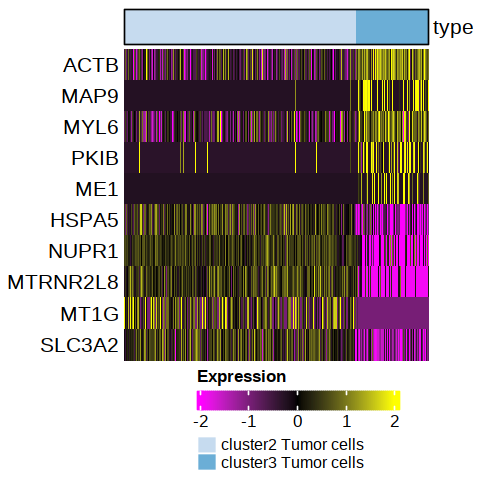

In [21]:

list_markers <- find_markers(rna, sample1 = sample1,
                        sample_ref = sample_ref,
                        pattern_sample1 = pattern_sample1,
                        pattern_sample_ref = pattern_sample_ref,
                             
                        # pattern_tumor_epi     
                        pattern_cell_type1 = pattern_tumor_epi,
                        pattern_cell_type_ref = pattern_tumor_epi,
                             
                        # cluster number
                        str_column_of_meta_data_cluster = str_column_of_meta_data_cluster,
                        clusters1 = clusters1,
                        clusters_ref = clusters_ref,
                             
                        group_name1 = sprintf("%s Tumor cells", group_name1),
                        group_name_ref = sprintf("%s Tumor cells", group_name_ref),
                        col_cluster_types = col_cluster_types_,
                        col_cell_types = col_cell_types_,
                        th_log2fc = th_log2fc_,
                        th_padj = th_padj_, 
                        min.pct = min.pct_,
                        min.diff.pct = min.diff.pct_,
                        max.cells.per.ident = max.cells.per.ident_,
                        method_dge = method_dge)

str_condition_tmp <- sprintf("%s_%s_vs_%s_Tumor cells",
                             str_condition,
                             group_name_ref, group_name1)

if (type_condition != "none") {
          str_condition_tmp <- sprintf("%s_%s", str_condition_tmp, type_condition)
}

list_ea <- execute_enrichment_analysis(list_markers$markers,
                        str_condition_tmp,
                        th_log2fc = th_log2fc_,
                        th_padj = th_padj_,
                        method_dge = method_dge,
                        dir_xlsx = dir_xlsx,       
                        n_log = 1)


genes_up <- rownames(list_ea$df_up)
genes_dn <- rownames(list_ea$df_dn)
list_genes_dn[["Epi"]] <- genes_dn

if (f_featureplot) {
    gg <- featureplot_enrichment_analysis(rna,
                list_ea,
                str_condition_tmp)
}

list_out_heatmap <- heatmap_enrichment_analysis(list_markers,
                    list_ea,
                    str_condition_tmp,
                    pattern_gene_removal="^MT-|^RPS|^RPL",
                    max_up=5, max_dn=5,
                    n_sampling=n_sampling,
                    cluster_rows=cluster_rows)



## cluster 2 vs. cluster 12

In [22]:
# tumor pairs with large differences

sample1 <- NULL
sample_ref <- NULL

th_log2fc_=0.25; th_padj_=0.01
min.pct_=0.25; min.diff.pct_=-Inf; max.cells.per.ident_=Inf

f_featureplot=FALSE
n_sampling=-1
cluster_rows=FALSE

pattern_sample1 <- "Tamoxifen"
pattern_sample_ref <- "Tamoxifen"

drug_name <- "tamoxifen"

#clusters1 <- c(3)  # 2 vs. 3 LumA, n=865
clusters1 <- c(12)  # 2 vs. 12 LumA, n=345
#clusters1 <- c(3,12)  # 2 vs. (3+12) LumA, n=1210
#clusters1 <- c(19)  # 2 vs. 19 LumB, n=100

clusters_ref <- c(2) # reponsive, n=2100

group_name1 <- sprintf("cluster%s", paste(clusters1, collapse=","))
group_name_ref <- sprintf("cluster%s", paste(clusters_ref, collapse=","))

col_cluster_types_ <- NULL
col_cell_types_ <- "cell.type"



In [23]:

cat(sprintf("sample1=%s\n", sample1))
cat(sprintf("sample_ref=%s\n", sample_ref))

cat(sprintf("drug_name=%s\n", drug_name))
cat(sprintf("pattern_sample1=%s\n", pattern_sample1))
cat(sprintf("pattern_sample_ref=%s\n", pattern_sample_ref))

    cat(sprintf("\t\tgroup_name1=%s\n", group_name1))
    cat(sprintf("\t\tgroup_name_ref=%s\n", group_name_ref))
    cat(sprintf("\t\tcol_cluster_types_=%s\n", col_cluster_types_))
    cat(sprintf("\t\tcol_cell_types_=%s\n", col_cell_types_))

    cat(sprintf("\t\tth_log2fc=%g\n", th_log2fc_))
    cat(sprintf("\t\tth_padj=%g\n", th_padj_))
    cat(sprintf("\t\tmin.pct=%g\n", min.pct_))
    cat(sprintf("\t\tmin.diff.pct=%g\n", min.diff.pct_))
    cat(sprintf("\t\tmax.cells.per.ident=%g\n", max.cells.per.ident_))
    cat(sprintf("\t\tmethod_dge=%s\n", method_dge))

    cat(sprintf("\t\ttype_condition=%s\n", type_condition))
    cat(sprintf("\t\tgenes=%s\n", paste(genes, collapse=", ")))
    cat(sprintf("\t\tstr_cond1=%s\n", str_cond1))
    cat(sprintf("\t\tstr_cond_ref=%s\n", str_cond_ref))



drug_name=tamoxifen
pattern_sample1=Tamoxifen
pattern_sample_ref=Tamoxifen
		group_name1=cluster12
		group_name_ref=cluster2
		col_cell_types_=cell.type
		th_log2fc=0.25
		th_padj=0.01
		min.pct=0.25
		min.diff.pct=-Inf
		max.cells.per.ident=Inf
		method_dge=seurat_findmarkers_enricher
		type_condition=none
		genes=


seurat_findmarkers_enricher         col_log2fc=avg_log2FC         col_pvalue=p_val         col_padj=p_val_adj         th_log2fc=0.25         th_padj=0.01

df_up

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,expr_min,expr_mean,expr_max
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ATP5MC3,2.232368e-160,1.2140738,1.000,0.940,5.425993e-156,1.14483079,2.1040055,2.858964
MYL6,5.184565e-160,1.2595958,1.000,1.000,1.260160e-155,2.65452665,3.3894687,4.065704
ACTB,3.137859e-158,1.7657372,1.000,0.977,7.626881e-154,1.63721004,3.1361429,4.101061
DYNLL1,7.563499e-155,1.4572730,1.000,0.901,1.838384e-150,0.96466962,2.2702212,3.064603
LY6E,2.986751e-149,0.6825340,0.885,0.215,7.259597e-145,-0.06104762,0.5456860,1.474264
PKIB,3.513621e-147,0.3459165,0.578,0.034,8.540207e-143,-0.16434295,0.2168596,1.452402


[1] 531   8

df_dn

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,expr_min,expr_mean,expr_max
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SLC3A2,9.713929e-183,-2.272678,0.997,1.000,2.361068e-178,0,1.5293648,3.180158
NUPR1,5.653467e-175,-2.134931,0.652,1.000,1.374132e-170,0,1.2106824,3.367310
HSPA5,6.182296e-173,-2.493555,0.991,0.998,1.502669e-168,0,1.0624772,3.198018
DDIT3,2.407137e-166,-2.582003,0.676,0.976,5.850788e-162,0,0.4161904,1.635127
HERPUD1,5.149551e-164,-2.053970,0.428,0.970,1.251650e-159,0,0.2625473,2.032582
MTRNR2L8,6.341356e-157,-2.224923,0.469,1.000,1.541330e-152,0,0.9506590,3.273059


[1] 909   8

up h

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
HALLMARK_OXIDATIVE_PHOSPHORYLATION,HALLMARK_OXIDATIVE_PHOSPHORYLATION,HALLMARK_OXIDATIVE_PHOSPHORYLATION,49/265,200/4386,1.516489e-18,7.582444e-17,6.704476e-17,NDUFA4/NDUFV2/ATP6V0E1/LDHA/COX6B1/NDUFC2/NDUFB3/NDUFAB1/NDUFS6/NDUFB4/TIMM8B/COX5A/UQCR10/COX6C/UQCRH/NDUFB7/COX7A2/UQCRQ/COX5B/COX6A1/CYB5A/NDUFA2/NDUFB6/ATP1B1/COX7C/NDUFB2/MGST3/NDUFB1/UQCR11/COX7B/LDHB/NDUFA3/NDUFC1/NDUFA8/VDAC3/SDHC/NDUFB8/COX4I1/ETFB/POLR2F/SLC25A5/HSD17B10/COX8A/UQCRB/MRPL34/MDH2/ECHS1/ATP6V1F/TIMM13,49
HALLMARK_MYC_TARGETS_V1,HALLMARK_MYC_TARGETS_V1,HALLMARK_MYC_TARGETS_V1,37/265,200/4386,3.274942e-10,8.187356e-09,7.239346e-09,LDHA/HSPE1/PSMB3/NDUFAB1/NME1/SNRPD3/PSMA7/COX5A/PPIA/SRSF2/SSBP1/RAN/PSMB2/UBE2L3/SRSF7/LSM2/SRSF3/PHB/SNRPD1/NHP2/PSMA4/CCT3/PSMA2/RANBP1/SNRPG/PGK1/VDAC3/CCT2/PSMA1/C1QBP/SNRPD2/ERH/SRPK1/HNRNPA2B1/LSM7/SET/CBX3,37
HALLMARK_GLYCOLYSIS,HALLMARK_GLYCOLYSIS,HALLMARK_GLYCOLYSIS,24/265,200/4386,8.214221e-04,1.369037e-02,1.210517e-02,LDHA/TXN/TPI1/STC1/MIF/PPIA/CYB5A/FKBP4/IGFBP3/PGK1/SDHC/TSTA3/TALDO1/ENO1/PGLS/SRD5A3/PLOD2/EGLN3/GLRX/PGAM1/MDH2/CLDN3/POLR3K/TFF3,24


[1] 3 9

up unc_lccc

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
T47D_control_vs_tamoxifen_down_Tumor cells,T47D_control_vs_tamoxifen_down_Tumor cells,T47D_control_vs_tamoxifen_down_Tumor cells,36/510,107/19993,9.375318e-31,3.412616e-28,2.417845e-28,ATP5MC3/DYNLL1/JPT1/KRT19/LDHA/MARCKSL1/NDUFC2/HSP90AA1/REEP5/SRSF7/FKBP4/CCT3/PSMA2/TUBB4B/SLC40A1/NDUFA8/VDAC3/TMBIM4/NDUFB8/CCT2/TRPS1/ENO1/SFPQ/SNRPB/ERH/ARL3/HNRNPM/TSFM/ID1/MRPL13/CALM2/HNRNPA2B1/RUNX1/CALM3/GOLM1/MRPL22,36
MITO1_BMC.Med.Genomics.2011_PMID.21214954,MITO1_BMC.Med.Genomics.2011_PMID.21214954,MITO1_BMC.Med.Genomics.2011_PMID.21214954,20/510,38/19993,2.066916e-22,3.761788e-20,2.665234e-20,DYNLL1/POMP/TXN/GEMIN6/TIMM8B/TMA7/COX7A2/UQCRQ/COX5B/COX6A1/COX7C/NDUFB2/NDUFB1/UQCR11/LSM5/SEM1/NDUFC1/ORMDL2/COX8A/MRPL22,20
GATA3.induced.genes_JCO.2006_PMID.16505416,GATA3.induced.genes_JCO.2006_PMID.16505416,GATA3.induced.genes_JCO.2006_PMID.16505416,39/510,277/19993,3.475322e-18,4.216724e-16,2.987558e-16,KRT19/KRT8/S100A11/CD24/VAMP8/TACSTD2/HSPB1/KRT18/GATA3/CD9/CITED4/TSPAN15/FXYD3/ATP1B1/SMIM22/KRT7/ADIRF/CALM1/SLC9A3R1/CYP1B1/TMC5/NDUFB9/BATF/TM4SF1/XBP1/OCIAD2/MYOF/SQOR/S100A16/RER1/ID1/MRPL13/CLDN3/TMEM165/S100A6/TFF3/LGALS1/STARD10/AQP3,39
MITO2_BMC.Med.Genomics.2011_PMID.21214954,MITO2_BMC.Med.Genomics.2011_PMID.21214954,MITO2_BMC.Med.Genomics.2011_PMID.21214954,19/510,78/19993,6.384692e-14,5.810070e-12,4.116446e-12,NDUFA4/HSPE1/GTF2A2/ARPC3/NDUFB3/NDUFAB1/UBL5/NDUFB6/PIGF/LAMTOR5/COX7B/TMEM14B/PSMA2/SNRPG/FKBP3/LSM3/PSMA3/PSMA5/RPA3,19
GSEA_GP1_Proliferation_DNA_repair.r=0.972_REACTOME_CELL_CYCLE_MITOTIC,GSEA_GP1_Proliferation_DNA_repair.r=0.972_REACTOME_CELL_CYCLE_MITOTIC,GSEA_GP1_Proliferation_DNA_repair.r=0.972_REACTOME_CELL_CYCLE_MITOTIC,31/510,319/19993,2.044951e-10,1.488724e-08,1.054764e-08,DYNLL1/HSP90AA1/SKP1/PSMB3/PSMA7/PSMB1/HDAC1/CCND1/PSMB5/PSMB2/PSMB7/UBA52/RPS27A/PSMB8/ANAPC11/TUBB/PSMA4/PSMA2/TUBB4B/PSMB6/PSMA1/PSME2/PSMD2/PSMA3/PSMC1/SSNA1/PSMA5/RPA3/PSMC3/TUBA1A/PSME1,31
Claudin_Low_Genome.Biol.2007_PMID.17493263,Claudin_Low_Genome.Biol.2007_PMID.17493263,Claudin_Low_Genome.Biol.2007_PMID.17493263,26/510,244/19993,8.463813e-10,5.134713e-08,3.637955e-08,PKIB/KRT19/HSPE1/TACSTD2/KRT18/GATA3/MIF/CD9/MUC1/FXYD3/FKBP4/PBX1/EFHD1/EMP2/PAFAH1B3/EPPK1/TRPS1/RAB25/KRTCAP3/POLR2H/TMEM54/CLDN3/GOLM1/CTTN/STARD10/GPRC5A,26


[1] 75  9

down h

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
HALLMARK_UNFOLDED_PROTEIN_RESPONSE,HALLMARK_UNFOLDED_PROTEIN_RESPONSE,HALLMARK_UNFOLDED_PROTEIN_RESPONSE,44/316,113/4386,1.772890e-22,8.509872e-21,6.718320e-21,HSPA5/HERPUD1/HSP90B1/SERP1/ATF4/CEBPG/MTHFD2/DDX10/ATF3/ASNS/CALR/HSPA9/HYOU1/PDIA6/DNAJB9/VEGFA/DNAJC3/IARS/SRPRB/SLC1A4/SSR1/EIF4EBP1/WIPI1/EIF2AK3/SEC31A/TARS/CKS1B/CEBPB/TSPYL2/ERN1/DDIT4/FKBP14/PSAT1/EEF2/XPOT/EXOSC1/KIF5B/PDIA5/CHAC1/SPCS3/ATF6/PREB/STC2/EDEM1,44
HALLMARK_MTORC1_SIGNALING,HALLMARK_MTORC1_SIGNALING,HALLMARK_MTORC1_SIGNALING,53/316,200/4386,4.257120e-18,1.021709e-16,8.066122e-17,NUPR1/HSPA5/DDIT3/HSP90B1/SERP1/SQSTM1/TRIB3/MTHFD2/PHGDH/FAM129A/TCEA1/SDF2L1/CANX/ASNS/CALR/HSPA9/PPP1R15A/EIF2S2/SQLE/EPRS/GOT1/IDI1/SLC1A4/SSR1/HMGCR/UFM1/HMGCS1/FKBP2/IFRD1/RPN1/TXNRD1/SHMT2/SLC7A11/LDLR/SLC1A5/INSIG1/DDIT4/PSAT1/BHLHE40/RAB1A/GGA2/USO1/HSPD1/NAMPT/UBE2D3/CYP51A1/WARS/SLC2A1/YKT6/NFKBIB/EDEM1/GCLC/HK2,53
HALLMARK_TNFA_SIGNALING_VIA_NFKB,HALLMARK_TNFA_SIGNALING_VIA_NFKB,HALLMARK_TNFA_SIGNALING_VIA_NFKB,42/316,200/4386,8.302605e-11,1.328417e-09,1.048750e-09,SQSTM1/EIF1/ATF3/PPP1R15A/GEM/BTG1/VEGFA/IRF1/CD44/JUN/DUSP1/KLF6/HBEGF/TSC22D1/CEBPB/LDLR/PNRC1/TRIB1/TGIF1/BHLHE40/RIPK2/MAFF/IRS2/REL/MXD1/SDC4/CCNL1/PHLDA2/NFKBIA/NFE2L2/KLF4/TNIP1/FOSL2/GADD45A/EFNA1/MYC/NAMPT/ZFP36/GADD45B/LITAF/IFIH1/PMEPA1,42
HALLMARK_PROTEIN_SECRETION,HALLMARK_PROTEIN_SECRETION,HALLMARK_PROTEIN_SECRETION,26/316,96/4386,1.455209e-09,1.746251e-08,1.378619e-08,LMAN1/ARFGAP3/COPE/ARF1/GOLGA4/SEC24D/RAB5A/SEC31A/ARCN1/TMED10/COPB2/DST/RAB9A/TPD52/ICA1/NAPA/USO1/COPB1/SEC22B/TMED2/BET1/RAB22A/VPS4B/TOM1L1/YKT6/BNIP3,26
HALLMARK_CHOLESTEROL_HOMEOSTASIS,HALLMARK_CHOLESTEROL_HOMEOSTASIS,HALLMARK_CHOLESTEROL_HOMEOSTASIS,19/316,74/4386,6.403518e-07,6.147378e-06,4.853193e-06,TRIB3/FAM129A/ATF3/SQLE/STX5/IDI1/HMGCR/TNFRSF12A/HMGCS1/LDLR/MVD/ERRFI1/FDPS/PNRC1/SREBF2/ALCAM/ECH1/CPEB2/CYP51A1,19
HALLMARK_HYPOXIA,HALLMARK_HYPOXIA,HALLMARK_HYPOXIA,34/316,200/4386,1.375148e-06,1.100118e-05,8.685145e-06,HSPA5/DDIT3/MT1E/MT2A/ATF3/PPP1R15A/BTG1/VEGFA/HMOX1/JUN/DUSP1/BNIP3L/KLF6/HDLBP/ERRFI1/DDIT4/PNRC1/WSB1/KLHL24/BHLHE40/TPD52/MAFF/IRS2/NEDD4L/SDC4/FOSL2/EFNA1/ZFP36/ISG20/SIAH2/STC2/SLC2A1/HK2/ZNF292,34


[1] 9 9

down unc_lccc

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
UNC_HS_Red22_BMC.Med.Genomics.2011_PMID.21214954,UNC_HS_Red22_BMC.Med.Genomics.2011_PMID.21214954,UNC_HS_Red22_BMC.Med.Genomics.2011_PMID.21214954,84/880,430/19993,1.492977e-31,5.927120e-29,4.510363e-29,HSP90B1/SERP1/MTHFD2/GFPT1/ARFGAP3/KDELR2/RSL24D1/TMEM258/DNAJB9/CCPG1/TMED5/MAP1LC3B/SLK/IDI1/SEC24D/JMJD1C/UFM1/EIF5/EIF2AK3/TARS/MAPK6/HSPA13/ARCN1/ACBD3/COPB2/SEC61G/CYCS/PRELID3B/SRP19/LRIF1/ARL8B/MCFD2/ARL1/CHMP2B/TXNRD1/CALCOCO2/GHITM/SRP54/BNIP2/PPP1R2/TDG/RNF6/XPOT/RAB9A/NRBF2/SUCO/GOLT1B/TCEAL9/USO1/TMEM106B/KIF5B/USP16/CRY1/COPB1/PPP1CB/ZC3H15/CCDC47/ATG3/EXOSC8/SEC22B/CSGALNACT2/EMC2/BET1/ABI1/TIMM17A/CLINT1/TMEM39A/SPCS3/GNAI3/RAD23B/ADK/SCFD1/TERF2IP/BCAS2/ITGAV/INSIG2/SARAF/SELENOF/ABHD5/EIF1B/ATF2/TM9SF3/FEM1B/AIMP1,84
Duke_Module07_glucosedepletion_Mike_PMID.20335537,Duke_Module07_glucosedepletion_Mike_PMID.20335537,Duke_Module07_glucosedepletion_Mike_PMID.20335537,22/880,27/19993,7.333335e-26,1.455667e-23,1.107719e-23,SLC3A2/HERPUD1/SDF2L1/HYOU1/EPRS/DNAJB9/MAP1LC3B/YARS/CLIC4/SEL1L/SLC38A2/IFRD1/CARS/DDIT4/KLHL24/CALU/HBP1/NFE2L1/TMEM106B/TERF2IP/WARS/SEC63,22
UNC_HS_Green16_BMC.Med.Genomics.2011_PMID.21214954,UNC_HS_Green16_BMC.Med.Genomics.2011_PMID.21214954,UNC_HS_Green16_BMC.Med.Genomics.2011_PMID.21214954,50/880,276/19993,9.896916e-18,1.309692e-15,9.966368e-16,HSP90B1/GNL3/GOLGA4/RB1CC1/LRRFIP1/TMF1/GOLGB1/SLK/JMJD1C/CCDC186/TAX1BP1/CLIP1/CIR1/SMG1/DAAM1/TRIP11/ANKRD12/CHD9/ZNF91/KLHL24/RSF1/SREK1/DEK/UPF2/CCNL1/KIF5B/USP16/FNBP4/UPF3B/SRSF11/PPIG/RSRC2/ZC3H15/OFD1/EMC2/EIF4G3/PKN2/NKTR/USP1/PHF20L1/SHOC2/USP47/PFDN2/SELENOP/BTBD7/ANKRD11/HOOK1/BRWD1/CHORDC1/TWISTNB,50
UNC_Unknown_10_BMC.Med.Genomics.2011_PMID.21214954,UNC_Unknown_10_BMC.Med.Genomics.2011_PMID.21214954,UNC_Unknown_10_BMC.Med.Genomics.2011_PMID.21214954,17/880,29/19993,2.370459e-16,2.352681e-14,1.790320e-14,PDIA3/PPIB/TMED9/KDELR2/SLC39A7/SRPRB/CKAP4/SEC61A1/COPB2/RPN1/GORASP2/COPG1/DAP/RABAC1/PDIA5/SEC13/YKT6,17
Duke_Module05_egfr_Mike_PMID.20335537,Duke_Module05_egfr_Mike_PMID.20335537,Duke_Module05_egfr_Mike_PMID.20335537,48/880,281/19993,5.099745e-16,4.049197e-14,3.081319e-14,SQLE/ATXN1/BTG1/VEGFA/STX3/CD44/HMGCR/GOLGA2/DUSP10/SEC31A/MAPK6/BNIP3L/SLC38A2/ACBD3/KLF6/INTS6/ARL8B/LRRFIP2/TSC22D1/DAAM1/CDYL/CEBPB/LDLR/DDIT4/WSB1/TRIB1/EHF/DST/BHLHE40/MAFF/CSNK1A1/CCNL1/NFKBIA/TNIP1/KMT2A/GADD45A/EFNA1/ZFP36/ISG20/RAB22A/SVIL/INSIG2/SLC2A1/SEC24A/GCLC/MACF1/FEM1B/N4BP1,48
UNC_HS_Red17_BMC.Med.Genomics.2011_PMID.21214954,UNC_HS_Red17_BMC.Med.Genomics.2011_PMID.21214954,UNC_HS_Red17_BMC.Med.Genomics.2011_PMID.21214954,52/880,335/19993,1.882687e-15,1.245711e-13,9.479495e-14,PDIA3/LMAN1/PPIB/JUND/CANX/ARF4/ARF1/P4HB/PJA2/TMCO3/TRAM1/SRPRA/CDV3/PSAP/MAP1LC3B/STX3/SSR1/CLIC4/RAB5A/KLF6/GCLM/PGM3/MBNL2/DNAJC10/CDYL/TRIM27/PPP1R2/YIPF5/EIF2S3/EHF/NEU1/RAB9A/RAB1A/CALU/PTP4A1/KPNA4/KIF5B/KDELR1/NFE2L2/SH3GLB1/TMOD3/TMED2/CREBZF/PPIF/UBE2D3/TKT/GNAI3/DDX3X/UBE2H/MAX/CBX4/CAPN7,52


[1] 74  9

filename_xlsx: xlsx/er+bc-pairs_cluster2_vs_cluster12_Tumor_cells.xlsx

filename_figure: heatmap_er+bc-pairs_cluster2_vs_cluster12_Tumor_cells_zscore

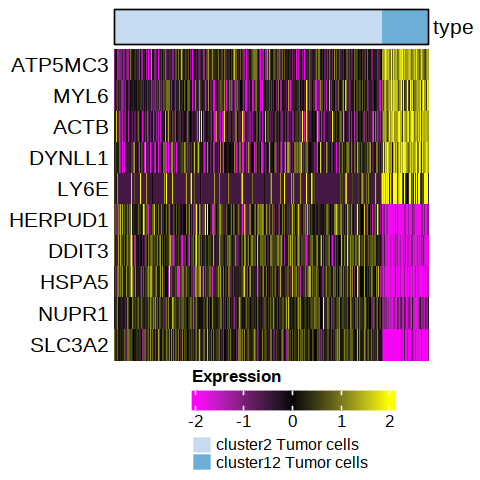

In [24]:

list_markers <- find_markers(rna, sample1 = sample1,
                        sample_ref = sample_ref,
                        pattern_sample1 = pattern_sample1,
                        pattern_sample_ref = pattern_sample_ref,
                             
                        # pattern_tumor_epi     
                        pattern_cell_type1 = pattern_tumor_epi,
                        pattern_cell_type_ref = pattern_tumor_epi,
                             
                        # cluster number
                        str_column_of_meta_data_cluster = str_column_of_meta_data_cluster,
                        clusters1 = clusters1,
                        clusters_ref = clusters_ref,
                             
                        group_name1 = sprintf("%s Tumor cells", group_name1),
                        group_name_ref = sprintf("%s Tumor cells", group_name_ref),
                        col_cluster_types = col_cluster_types_,
                        col_cell_types = col_cell_types_,
                        th_log2fc = th_log2fc_,
                        th_padj = th_padj_, 
                        min.pct = min.pct_,
                        min.diff.pct = min.diff.pct_,
                        max.cells.per.ident = max.cells.per.ident_,
                        method_dge = method_dge)

str_condition_tmp <- sprintf("%s_%s_vs_%s_Tumor cells",
                             str_condition,
                             group_name_ref, group_name1)

if (type_condition != "none") {
          str_condition_tmp <- sprintf("%s_%s", str_condition_tmp, type_condition)
}

list_ea <- execute_enrichment_analysis(list_markers$markers,
                        str_condition_tmp,
                        th_log2fc = th_log2fc_,
                        th_padj = th_padj_,
                        method_dge = method_dge,
                        dir_xlsx = dir_xlsx,       
                        n_log = 1)


genes_up <- rownames(list_ea$df_up)
genes_dn <- rownames(list_ea$df_dn)
list_genes_dn[["Epi"]] <- genes_dn

if (f_featureplot) {
    gg <- featureplot_enrichment_analysis(rna,
                list_ea,
                str_condition_tmp)
}

list_out_heatmap <- heatmap_enrichment_analysis(list_markers,
                    list_ea,
                    str_condition_tmp,
                    pattern_gene_removal="^MT-|^RPS|^RPL",
                    max_up=5, max_dn=5,
                    n_sampling=n_sampling,
                    cluster_rows=cluster_rows)



## cluster 2 vs. cluster 19

In [25]:
# tumor pairs with large differences

sample1 <- NULL
sample_ref <- NULL

th_log2fc_=0.25; th_padj_=0.01
min.pct_=0.25; min.diff.pct_=-Inf; max.cells.per.ident_=Inf

f_featureplot=FALSE
n_sampling=-1
cluster_rows=FALSE

pattern_sample1 <- "Tamoxifen"
pattern_sample_ref <- "Tamoxifen"

drug_name <- "tamoxifen"

#clusters1 <- c(3)  # 2 vs. 3 LumA, n=865
#clusters1 <- c(12)  # 2 vs. 12 LumA, n=345
#clusters1 <- c(3,12)  # 2 vs. (3+12) LumA, n=1210
clusters1 <- c(19)  # 2 vs. 19 LumB, n=100

clusters_ref <- c(2) # reponsive, n=2100

group_name1 <- sprintf("cluster%s", paste(clusters1, collapse=","))
group_name_ref <- sprintf("cluster%s", paste(clusters_ref, collapse=","))

col_cluster_types_ <- NULL
col_cell_types_ <- "cell.type"



In [26]:

cat(sprintf("sample1=%s\n", sample1))
cat(sprintf("sample_ref=%s\n", sample_ref))

cat(sprintf("drug_name=%s\n", drug_name))
cat(sprintf("pattern_sample1=%s\n", pattern_sample1))
cat(sprintf("pattern_sample_ref=%s\n", pattern_sample_ref))

    cat(sprintf("\t\tgroup_name1=%s\n", group_name1))
    cat(sprintf("\t\tgroup_name_ref=%s\n", group_name_ref))
    cat(sprintf("\t\tcol_cluster_types_=%s\n", col_cluster_types_))
    cat(sprintf("\t\tcol_cell_types_=%s\n", col_cell_types_))

    cat(sprintf("\t\tth_log2fc=%g\n", th_log2fc_))
    cat(sprintf("\t\tth_padj=%g\n", th_padj_))
    cat(sprintf("\t\tmin.pct=%g\n", min.pct_))
    cat(sprintf("\t\tmin.diff.pct=%g\n", min.diff.pct_))
    cat(sprintf("\t\tmax.cells.per.ident=%g\n", max.cells.per.ident_))
    cat(sprintf("\t\tmethod_dge=%s\n", method_dge))

    cat(sprintf("\t\ttype_condition=%s\n", type_condition))
    cat(sprintf("\t\tgenes=%s\n", paste(genes, collapse=", ")))
    cat(sprintf("\t\tstr_cond1=%s\n", str_cond1))
    cat(sprintf("\t\tstr_cond_ref=%s\n", str_cond_ref))



drug_name=tamoxifen
pattern_sample1=Tamoxifen
pattern_sample_ref=Tamoxifen
		group_name1=cluster19
		group_name_ref=cluster2
		col_cell_types_=cell.type
		th_log2fc=0.25
		th_padj=0.01
		min.pct=0.25
		min.diff.pct=-Inf
		max.cells.per.ident=Inf
		method_dge=seurat_findmarkers_enricher
		type_condition=none
		genes=


seurat_findmarkers_enricher         col_log2fc=avg_log2FC         col_pvalue=p_val         col_padj=p_val_adj         th_log2fc=0.25         th_padj=0.01

df_up

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,expr_min,expr_mean,expr_max
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
TOP2A,0.000000e+00,1.1593298,0.879,0.006,0.000000e+00,0.0000000,0.6901799,1.926897
CDK1,4.990633e-295,0.7414686,0.758,0.005,1.213023e-290,0.0000000,0.4399324,1.545767
MKI67,5.111039e-279,0.9043770,0.736,0.006,1.242289e-274,0.0000000,0.5036200,1.937559
UBE2C,4.385772e-273,1.3403507,0.780,0.007,1.066006e-268,-0.1252316,0.7045849,2.829597
TPX2,3.843025e-228,0.9929080,0.780,0.019,9.340858e-224,0.0000000,0.5825409,1.611600
BIRC5,1.418652e-226,0.6672713,0.769,0.007,3.448175e-222,-0.2148748,0.3977608,1.383496


[1] 418   8

df_dn

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,expr_min,expr_mean,expr_max
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
MTRNR2L8,2.210859e-33,-1.6140513,0.549,1.000,5.373713e-29,0.000000,1.2683929,3.246989
NUPR1,8.225728e-28,-1.1553518,0.648,1.000,1.999346e-23,0.000000,1.6534718,3.398099
PDIA3,3.311991e-26,-0.9265955,0.890,0.976,8.050126e-22,0.000000,0.9399822,1.924883
SERP1,1.753406e-25,-0.7642184,1.000,0.998,4.261830e-21,1.122851,2.1751693,3.015434
HSPA5,2.985320e-25,-1.1131688,0.868,0.998,7.256120e-21,0.000000,1.6558417,4.022385
SNHG8,5.763676e-24,-1.0162771,0.846,0.994,1.400919e-19,0.000000,1.4529309,2.854998


[1] 188   8

up h

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
HALLMARK_G2M_CHECKPOINT,HALLMARK_G2M_CHECKPOINT,HALLMARK_G2M_CHECKPOINT,62/249,200/4386,1.767233e-31,8.305996e-30,7.254957e-30,TOP2A/CDK1/MKI67/UBE2C/TPX2/BIRC5/CENPF/NEK2/PRC1/MYBL2/PBK/TROAP/KIF4A/KIF11/CCNB2/CDC20/MAD2L1/KIF2C/HMMR/CCNA2/E2F1/KIF23/NUSAP1/CENPA/ORC6/RACGAP1/CHEK1/PLK1/AURKA/PTTG1/CKS2/KIF20B/BARD1/CENPE/HMGB3/STMN1/CDC25B/SMC4/UBE2S/SMC2/MCM3/HIF1A/TMPO/HMGN2/CCND1/DTYMK/CDKN3/SNRPD1/H2AFZ/SAP30/SLC12A2/SRSF2/ODC1/KPNA2/BCL3/XPO1/TFDP1/H2AFV/HSPA8/NASP/SFPQ/CKS1B,62
HALLMARK_E2F_TARGETS,HALLMARK_E2F_TARGETS,HALLMARK_E2F_TARGETS,61/249,200/4386,1.682299e-30,3.953403e-29,3.453141e-29,TOP2A/CDK1/MKI67/BIRC5/SPC25/MYBL2/KIF4A/UBE2T/DIAPH3/CCNB2/CDC20/MAD2L1/KIF2C/HMMR/RRM2/TK1/HELLS/RAD51AP1/ORC6/RACGAP1/CHEK1/PLK1/AURKA/ATAD2/PTTG1/CKS2/HMGB2/BARD1/CENPE/RFC3/HMGB3/STMN1/CDCA8/BRCA1/CDC25B/DUT/SMC4/UBE2S/MCM3/TMPO/ANP32E/CDKN3/H2AFZ/CSE1L/RPA3/RANBP1/CENPM/TUBG1/TUBB/SRSF2/RAN/KPNA2/NME1/SNRPB/XPO1/PCNA/PA2G4/MCM4/NASP/CKS1B/DNMT1,61
HALLMARK_MYC_TARGETS_V1,HALLMARK_MYC_TARGETS_V1,HALLMARK_MYC_TARGETS_V1,40/249,200/4386,5.295716e-13,8.296622e-12,7.246769e-12,CDC20/MAD2L1/CCNA2/TYMS/DUT/RRM1/SNRPD1/H2AFZ/PPIA/HNRNPA2B1/RANBP1/PSMA7/SRSF2/RAN/CBX3/SRSF3/ODC1/KPNA2/PSMB3/LDHA/NME1/SRSF7/PSMA4/PSMA2/XPO1/COX5A/CCT2/PCNA/PSMD1/LSM2/SSBP1/TFDP1/ERH/PA2G4/C1QBP/HDAC2/MCM4/SNRPD2/HSPE1/SET,40
HALLMARK_MITOTIC_SPINDLE,HALLMARK_MITOTIC_SPINDLE,HALLMARK_MITOTIC_SPINDLE,28/249,200/4386,5.671408e-06,6.663904e-05,5.820655e-05,TOP2A/CDK1/TPX2/BIRC5/ANLN/CENPF/NEK2/PRC1/KIF4A/KIF11/CCNB2/KIF2C/KIF23/NUSAP1/RACGAP1/PLK1/AURKA/KIF20B/CENPE/ECT2/SMC4/NET1/CDC42EP4/FLNA/CKAP5/PDLIM5/SSH2/ARF6,28
HALLMARK_MTORC1_SIGNALING,HALLMARK_MTORC1_SIGNALING,HALLMARK_MTORC1_SIGNALING,22/249,200/4386,1.882983e-03,1.770004e-02,1.546028e-02,RRM2/PLK1/AURKA/PLOD2/GAPDH/STC1/PPIA/EGLN3/CCT6A/TPI1/TUBG1/CACYBP/XBP1/LDHA/PSMA4/ENO1/GLRX/MCM4/PRDX1/HSPE1/CD9/STIP1,22
HALLMARK_GLYCOLYSIS,HALLMARK_GLYCOLYSIS,HALLMARK_GLYCOLYSIS,21/249,200/4386,4.180734e-03,3.274908e-02,2.860502e-02,CDK1/HMMR/CENPA/AURKA/PLOD2/STMN1/TXN/STC1/PPIA/EGLN3/SAP30/TPI1/MIF/GALK1/LDHA/ENO1/GLRX/PGAM1/NASP/FUT8/FKBP4,21


[1] 6 9

up unc_lccc

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
Wirapati_Proliferation_Breast.Cancer.Res.2008_PMID.18662380,Wirapati_Proliferation_Breast.Cancer.Res.2008_PMID.18662380,Wirapati_Proliferation_Breast.Cancer.Res.2008_PMID.18662380,103/410,354/19993,6.765447e-91,2.415265e-88,1.630829e-88,TOP2A/CDK1/MKI67/UBE2C/TPX2/BIRC5/ANLN/PCLAF/CENPF/IQGAP3/NEK2/SPC25/PRC1/MYBL2/ZWINT/PBK/SHCBP1/PKMYT1/FAM83D/TROAP/KIF4A/UBE2T/ASPM/KIF11/DIAPH3/CENPK/CEP55/CCNB2/CDC20/KNL1/NCAPH/NUF2/MAD2L1/KIF2C/HMMR/CCNA2/E2F1/RRM2/KIF23/NUSAP1/KIFC1/TK1/CENPA/HELLS/RAD51AP1/CENPW/ORC6/RACGAP1/CCNB1/CENPU/CHEK1/PLK1/AURKA/ATAD2/GTSE1/PTTG1/FANCI/CKS2/HMGB2/TYMS/CENPE/HMGB3/STMN1/CDCA8/TUBA1B/ECT2/CDC25B/SMC4/UBE2S/VRK1/MCM3/MIS18A/JPT1/NUDT1/DTYMK/CDKN3/SNRPD1/CKAP2/LRR1/H2AFZ/GMNN/ARL6IP1/CCT6A/CSE1L/HNRNPA2B1/TPI1/PSMA7/CENPM/SNRPF/TUBG1/CKAP5/KPNA2/ALYREF/XPO1/COX5A/PCNA/CENPX/LAPTM4B/H2AFV/MCM4/FAM136A/CKS1B/DNMT1,103
Proliferation_Cluster_BMC.Med.Genomics.2011_PMID.21214954,Proliferation_Cluster_BMC.Med.Genomics.2011_PMID.21214954,Proliferation_Cluster_BMC.Med.Genomics.2011_PMID.21214954,60/410,121/19993,3.984606e-69,7.112521e-67,4.802499e-67,TOP2A/CDK1/MKI67/UBE2C/TPX2/PCLAF/CENPF/NEK2/SPC25/PRC1/MYBL2/ZWINT/PBK/SHCBP1/TROAP/KIF4A/ASPM/KIF11/CEP55/CCNB2/CDC20/NCAPH/MAD2L1/KIF2C/HMMR/CCNA2/E2F1/RRM2/KIF23/NUSAP1/KIFC1/TK1/CENPA/RAD51AP1/ORC6/RACGAP1/CCNB1/CHEK1/AURKA/GTSE1/PTTG1/CKS2/TYMS/CENPE/STMN1/CDCA8/TUBA1B/ECT2/SMC4/UBE2S/MCM3/MIS18A/TMPO/CDKN3/H2AFZ/PSMA7/CENPM/CKAP5/PCNA/PDCD5,60
bMYB_Signature_Oncogene.2009_PMID.19043454,bMYB_Signature_Oncogene.2009_PMID.19043454,bMYB_Signature_Oncogene.2009_PMID.19043454,61/410,151/19993,2.525756e-63,3.005650e-61,2.029467e-61,TOP2A/CDK1/UBE2C/TPX2/BIRC5/ANLN/CENPF/PRC1/MYBL2/ZWINT/PBK/PKMYT1/FAM83D/TROAP/UBE2T/ASPM/KIF11/CEP55/CCNB2/CDC20/NCAPH/MAD2L1/KIF2C/HMMR/CCNA2/RRM2/KIF23/NUSAP1/TK1/RAD51AP1/ORC6/RACGAP1/CCNB1/CENPU/PLK1/ATAD2/CKS2/KIF20B/HMGB2/CENPE/RFC3/HMGB3/STMN1/CDCA8/BRCA1/ECT2/CDC25B/SMC4/VRK1/MCM3/NUDT1/CDKN3/H2AFZ/ARL6IP1/NMB/RPL39L/KPNA2/TCOF1/TM4SF1/MCM4/CKS1B,61
MProliferation_BMC.Med.Genomics.2011_PMID.21214954,MProliferation_BMC.Med.Genomics.2011_PMID.21214954,MProliferation_BMC.Med.Genomics.2011_PMID.21214954,59/410,145/19993,1.820109e-61,1.624447e-59,1.096855e-59,TOP2A/CDK1/UBE2C/TPX2/BIRC5/CENPF/NEK2/SGO1/SPC25/PRC1/PBK/SHCBP1/PKMYT1/FAM83D/KIF4A/UBE2T/ASPM/KIF11/CEP55/CCNB2/CDC20/KNL1/NUF2/MAD2L1/CCNA2/RRM2/NUSAP1/TK1/CENPA/HELLS/RAD51AP1/RACGAP1/CCNB1/CHEK1/PLK1/AURKA/GTSE1/CENPH/FANCI/CKS2/KIF20B/HMGB2/TYMS/CENPE/RFC3/STMN1/CDCA8/BRCA1/ECT2/DUT/SGO2/SMC4/SMC2/MCM3/RRM1/CKAP2/PCNA/MCM4/DNMT1,59
UNC_HS_Red23_BMC.Med.Genomics.2011_PMID.21214954,UNC_HS_Red23_BMC.Med.Genomics.2011_PMID.21214954,UNC_HS_Red23_BMC.Med.Genomics.2011_PMID.21214954,57/410,132/19993,3.256321e-61,2.325013e-59,1.569889e-59,TOP2A/CDK1/MKI67/UBE2C/TPX2/PCLAF/CENPF/NEK2/SPC25/PRC1/ZWINT/PBK/TROAP/KIF4A/ASPM/KIF11/CEP55/CCNB2/CDC20/NCAPH/MAD2L1/KIF2C/HMMR/CCNA2/E2F1/RRM2/KIF23/NUSAP1/KIFC1/TK1/CENPA/HELLS/RAD51AP1/RACGAP1/CCNB1/AURKA/ATAD2/PTTG1/CKS2/TYMS/BARD1/CENPE/CDCA8/ECT2/SMC4/UBE2S/SMC2/JPT1/NUDT1/CDKN3/CKAP2/H2AFZ/CENPM/TUBG1/CKAP5/PCNA/DNMT1,57
UNC_HS_Green10_BMC.Med.Genomics.2011_PMID.21214954,UNC_HS_Green10_BMC.Med.Genomics.2011_PMID.21214954,UNC_HS_Green10_BMC.Med.Genomics.2011_PMID.21214954,65/410,267/19993,3.865961e-51,2.300247e-49,1.553167e-49,TOP2A/CDK1/MKI67/UBE2C/TPX2/PCLAF/CENPF/NEK2/SPC25/PRC1/MYBL2/ZWINT/PBK/SHCBP1/TROAP/KIF4A/ASPM/KIF11/CEP55/CCNB2/CDC20/NCAPH/MAD2L1/KIF2C/HMMR/CCNA2/E2F1/RRM2/KIF23/NUSAP1/KIFC1/TK1/CENPA/HELLS/RAD51AP1/ORC6/RACGAP1/CCNB1/CHEK1/AURKA/GTSE1/S100A9/PTTG1/CKS2/TYMS/CENPE/HMGB3/CDCA8/BTG3/ECT2/CDC25B/UBE2S/JPT1/NUDT1/LY6E/CDKN3/CKAP2/GMNN/CENPM/TUBB4B/SNRPB/PCNA/LAPTM4B/NASP/RSRC1,65


[1] 96  9

down h

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
HALLMARK_UNFOLDED_PROTEIN_RESPONSE,HALLMARK_UNFOLDED_PROTEIN_RESPONSE,HALLMARK_UNFOLDED_PROTEIN_RESPONSE,21/85,113/4386,7.263414e-16,2.832732e-14,2.064339e-14,SERP1/HSPA5/DDX10/HERPUD1/ATF4/ASNS/CEBPG/DNAJC3/MTHFD2/DNAJB9/DDIT4/IARS/ATF3/SEC31A/PDIA6/CALR/VEGFA/HSP90B1/SSR1/FKBP14/PDIA5,21
HALLMARK_MTORC1_SIGNALING,HALLMARK_MTORC1_SIGNALING,HALLMARK_MTORC1_SIGNALING,25/85,200/4386,1.357551e-14,2.647225e-13,1.929152e-13,NUPR1/SERP1/HSPA5/SQSTM1/SDF2L1/TRIB3/DDIT3/ASNS/TCEA1/MTHFD2/TUBA4A/SQLE/HMGCR/PHGDH/HMGCS1/FAM129A/IDI1/DDIT4/SLC7A11/CALR/EPRS/HSP90B1/GOT1/TXNRD1/SSR1,25
HALLMARK_CHOLESTEROL_HOMEOSTASIS,HALLMARK_CHOLESTEROL_HOMEOSTASIS,HALLMARK_CHOLESTEROL_HOMEOSTASIS,9/85,74/4386,9.945769e-06,1.292950e-04,9.422308e-05,TRIB3/STX5/SQLE/HMGCR/HMGCS1/FAM129A/IDI1/ATF3/PNRC1,9
HALLMARK_ANDROGEN_RESPONSE,HALLMARK_ANDROGEN_RESPONSE,HALLMARK_ANDROGEN_RESPONSE,8/85,101/4386,6.663101e-04,6.496524e-03,4.734309e-03,HOMER2/PGM3/LMAN1/DNAJB9/HMGCR/HMGCS1/IDI1/SLC38A2,8
HALLMARK_PROTEIN_SECRETION,HALLMARK_PROTEIN_SECRETION,HALLMARK_PROTEIN_SECRETION,7/85,96/4386,2.368809e-03,1.847671e-02,1.346481e-02,ARFGAP3/LMAN1/COPE/SEC31A/RAB9A/ARF1/DST,7
HALLMARK_UV_RESPONSE_UP,HALLMARK_UV_RESPONSE_UP,HALLMARK_UV_RESPONSE_UP,9/85,158/4386,3.206121e-03,2.083978e-02,1.518689e-02,SQSTM1/ASNS/CEBPG/TUBA4A/HMOX1/BTG1/ATF3/DDX21/HSPA13,9


[1] 9 9

down unc_lccc

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
Duke_Module07_glucosedepletion_Mike_PMID.20335537,Duke_Module07_glucosedepletion_Mike_PMID.20335537,Duke_Module07_glucosedepletion_Mike_PMID.20335537,9/179,27/19993,1.232005e-12,2.993772e-10,2.295420e-10,SLC3A2/HERPUD1/SDF2L1/DNAJB9/DDIT4/SLC38A2/MAP1LC3B/EPRS/CALU,9
UNC_HS_Red22_BMC.Med.Genomics.2011_PMID.21214954,UNC_HS_Red22_BMC.Med.Genomics.2011_PMID.21214954,UNC_HS_Red22_BMC.Med.Genomics.2011_PMID.21214954,23/179,430/19993,6.597554e-12,8.016028e-10,6.146142e-10,SERP1/ARFGAP3/RSL24D1/GFPT1/KDELR2/MTHFD2/DNAJB9/TMED5/CCPG1/SEC61G/ARL1/IDI1/CALCOCO2/TMEM258/JMJD1C/SCFD1/RAB9A/ARL8B/MAP1LC3B/NRBF2/HSP90B1/TXNRD1/HSPA13,23
GSEA_HDAC_TARGETS_DN_HELLER,GSEA_HDAC_TARGETS_DN_HELLER,GSEA_HDAC_TARGETS_DN_HELLER,17/179,290/19993,1.080710e-09,8.350578e-08,6.402653e-08,PDIA3/SERP1/HSPA5/SLC3A2/HERPUD1/ATF4/TRIB3/DDIT3/CRELD2/CEBPG/DNAJB9/CCPG1/HMOX1/SLC7A11/ATF3/CALR/PMAIP1,17
UNC_HS_Red17_BMC.Med.Genomics.2011_PMID.21214954,UNC_HS_Red17_BMC.Med.Genomics.2011_PMID.21214954,UNC_HS_Red17_BMC.Med.Genomics.2011_PMID.21214954,18/179,335/19993,1.374581e-09,8.350578e-08,6.402653e-08,PDIA3/JUND/PPIB/PGM3/ARF4/SRPRA/LMAN1/TRAM1/PSAP/GCLM/P4HB/RAB9A/MAP1LC3B/PJA2/ARF1/TMCO3/CALU/SSR1,18
UNC_Unknown_10_BMC.Med.Genomics.2011_PMID.21214954,UNC_Unknown_10_BMC.Med.Genomics.2011_PMID.21214954,UNC_Unknown_10_BMC.Med.Genomics.2011_PMID.21214954,6/179,29/19993,1.895944e-07,9.214289e-06,7.064887e-06,PDIA3/PPIB/SLC39A7/KDELR2/TMED9/PDIA5,6
UNC_HS_Red14_BMC.Med.Genomics.2011_PMID.21214954,UNC_HS_Red14_BMC.Med.Genomics.2011_PMID.21214954,UNC_HS_Red14_BMC.Med.Genomics.2011_PMID.21214954,12/179,241/19993,1.881719e-06,7.620963e-05,5.843233e-05,NUPR1/SEPHS2/HOMER2/VAV3/DNAJC12/TCEA1/SQLE/TRAM1/OSER1/PGRMC2/SLC38A2/RB1CC1,12


[1] 37  9

filename_xlsx: xlsx/er+bc-pairs_cluster2_vs_cluster19_Tumor_cells.xlsx

filename_figure: heatmap_er+bc-pairs_cluster2_vs_cluster19_Tumor_cells_zscore

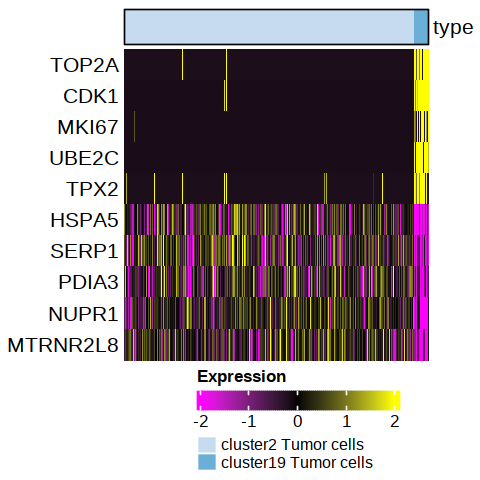

In [27]:

list_markers <- find_markers(rna, sample1 = sample1,
                        sample_ref = sample_ref,
                        pattern_sample1 = pattern_sample1,
                        pattern_sample_ref = pattern_sample_ref,
                             
                        # pattern_tumor_epi     
                        pattern_cell_type1 = pattern_tumor_epi,
                        pattern_cell_type_ref = pattern_tumor_epi,
                             
                        # cluster number
                        str_column_of_meta_data_cluster = str_column_of_meta_data_cluster,
                        clusters1 = clusters1,
                        clusters_ref = clusters_ref,
                             
                        group_name1 = sprintf("%s Tumor cells", group_name1),
                        group_name_ref = sprintf("%s Tumor cells", group_name_ref),
                        col_cluster_types = col_cluster_types_,
                        col_cell_types = col_cell_types_,
                        th_log2fc = th_log2fc_,
                        th_padj = th_padj_, 
                        min.pct = min.pct_,
                        min.diff.pct = min.diff.pct_,
                        max.cells.per.ident = max.cells.per.ident_,
                        method_dge = method_dge)

str_condition_tmp <- sprintf("%s_%s_vs_%s_Tumor cells",
                             str_condition,
                             group_name_ref, group_name1)

if (type_condition != "none") {
          str_condition_tmp <- sprintf("%s_%s", str_condition_tmp, type_condition)
}

list_ea <- execute_enrichment_analysis(list_markers$markers,
                        str_condition_tmp,
                        th_log2fc = th_log2fc_,
                        th_padj = th_padj_,
                        method_dge = method_dge,
                        dir_xlsx = dir_xlsx,       
                        n_log = 1)


genes_up <- rownames(list_ea$df_up)
genes_dn <- rownames(list_ea$df_dn)
list_genes_dn[["Epi"]] <- genes_dn

if (f_featureplot) {
    gg <- featureplot_enrichment_analysis(rna,
                list_ea,
                str_condition_tmp)
}

list_out_heatmap <- heatmap_enrichment_analysis(list_markers,
                    list_ea,
                    str_condition_tmp,
                    pattern_gene_removal="^MT-|^RPS|^RPL",
                    max_up=5, max_dn=5,
                    n_sampling=n_sampling,
                    cluster_rows=cluster_rows)



# session info

In [28]:
writeLines(capture.output(sessionInfo()), "txt/sessionInfo.txt")


# reference

https://satijalab.org/seurat/

